In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mtr

In [2]:
# Read VT data
data_df = pd.read_pickle("../data/interim/vtdata.pkl")
data_df = data_df.sample(frac=1, random_state=7).reset_index(drop=True)

vt_X = data_df.drop(columns="vt")
vt_y = data_df["vt"]

# ...and drop unwanted features to avoid spatial overfitting
vt_X = vt_X.drop(['x', 'y', 'plot_id'], axis=1)
print(vt_X.columns)
vt_X.head()

Index(['B11_median_comp_Sent2', 'B12_median_comp_Sent2',
       'B1_median_comp_Sent2', 'B2_median_comp_Sent2', 'B3_median_comp_Sent2',
       'B4_median_comp_Sent2', 'B5_median_comp_Sent2', 'B6_median_comp_Sent2',
       'B7_median_comp_Sent2', 'B8A_median_comp_Sent2', 'B8_median_comp_Sent2',
       'B9_median_comp_Sent2', 'EVI_greenest_pixel_Sent2',
       'EVI_median_comp_Sent2', 'GNDVI_greenest_pixel_Sent2',
       'GNDVI_median_comp_Sent2', 'NDMI_greenest_pixel_Sent2',
       'NDMI_median_comp_Sent2', 'NDVI_greenest_pixel_Sent2',
       'NDVI_median_comp_Sent2', 'SAVI_greenest_pixel_Sent2',
       'SAVI_median_comp_Sent2', 'B1_median_comp_Lands7',
       'B2_median_comp_Lands7', 'B3_median_comp_Lands7',
       'B4_median_comp_Lands7', 'B5_median_comp_Lands7',
       'B6_median_comp_Lands7', 'B7_median_comp_Lands7',
       'EVI_greenest_pixel_Lands7', 'EVI_median_comp_Lands7',
       'GNDVI_greenest_pixel_Lands7', 'GNDVI_median_comp_Lands7',
       'NDMI_greenest_pixel_Lands7', 'ND

,B11_median_comp_Sent2,B12_median_comp_Sent2,B1_median_comp_Sent2,B2_median_comp_Sent2,B3_median_comp_Sent2,B4_median_comp_Sent2,B5_median_comp_Sent2,B6_median_comp_Sent2,B7_median_comp_Sent2,B8A_median_comp_Sent2,...,tmax_6,tmax_8,tmax_9,tmin_5,tmin_9,topographic_wetness_index,total_insolation,valley_depth,vertical_distance_to_channel_network,visible_sky
0,0.21700,0.12775,0.04157,0.04070,0.05858,0.05915,0.10155,0.17385,0.19245,0.21790,...,20.5811,18.1146,12.9765,-4.5616,-1.6503,8.1780,1168.90918,121.9962,163.3139,94.1729
1,0.07680,0.03780,0.01560,0.01945,0.02982,0.01820,0.04752,0.12807,0.15217,0.16735,...,22.5382,20.2714,17.2824,0.7850,0.4542,6.8749,1211.49475,64.2473,25.2764,97.7724
2,0.20360,0.09220,0.06630,0.03990,0.06280,0.04020,0.12070,0.31450,0.35760,0.38720,...,17.6708,20.3218,14.5407,-3.4983,-2.3515,17.6024,993.73572,748.6170,0.0000,84.9623
3,0.22508,0.13655,0.02765,0.04070,0.06180,0.06697,0.11375,0.22545,0.25670,0.29110,...,21.9165,20.5618,15.8932,2.0480,4.8671,7.2655,1118.61890,103.4937,46.4838,94.7372
4,0.24625,0.13610,0.03075,0.04715,0.07305,0.07145,0.14155,0.25710,0.28145,0.31650,...,14.7530,16.7801,13.4581,-7.0645,-1.2334,7.3559,1399.06226,229.2504,62.1383,94.1043


In [3]:
# Load CV indices
with open('../data/misc/vtdata_5f_spatial_cv_indices.pkl', 'rb') as file:
    split_indices = pickle.load(file)

split_indices

[(array([    0,     1,     3, ..., 22168, 22169, 22170], dtype=int64),
  array([    2,     7,     9, ..., 22157, 22171, 22172], dtype=int64)),
 (array([    0,     1,     2, ..., 22170, 22171, 22172], dtype=int64),
  array([   14,    58,    67, ..., 22158, 22166, 22167], dtype=int64)),
 (array([    0,     1,     2, ..., 22168, 22171, 22172], dtype=int64),
  array([   11,    12,    23, ..., 22164, 22169, 22170], dtype=int64)),
 (array([    0,     2,     4, ..., 22170, 22171, 22172], dtype=int64),
  array([    1,     3,     6, ..., 22163, 22165, 22168], dtype=int64)),
 (array([    1,     2,     3, ..., 22170, 22171, 22172], dtype=int64),
  array([    0,     4,     5, ..., 22146, 22159, 22162], dtype=int64))]

In [4]:
rf_clf_class_scores = ["Precision", "Recall", "F1_score"]
rf_clf_total_scores = [
    "Overall_accuracy",
    "Macro_f1",
    "Cohen_kappa",
]

### Loop through indices, calculate metrics
rf_scoring_class_list = []
for idx in range(len(split_indices)):
    rf_scoring_class_list.append(
        pd.DataFrame(
            columns=[cur_fold+"_fold_"+str(idx+1) for cur_fold in rf_clf_class_scores]
        )
    )

rf_scoring_total_df = pd.DataFrame(columns=rf_clf_total_scores)

In [5]:
confusion_matrix_cv_results: list = []
rf_class_counter_train_df = pd.DataFrame()
rf_class_counter_test_df = pd.DataFrame()

for fold_counter, (fold_train_indices, fold_test_indices) in enumerate(split_indices):
    
    # Initialize RF classifier with tuned hyperparams
    rf = RandomForestClassifier(
        n_estimators=800,
        criterion='gini',
        max_depth=22,
        max_features=12,
        oob_score=True,
        verbose=0,
        n_jobs=-1,
        random_state=221,
    )
    
    print(f"Fitting Random Forest for fold {fold_counter+1}...", end='')
    rf.fit(
        X = vt_X.iloc[fold_train_indices, :],
        y = vt_y[fold_train_indices],
    )
    
    print(f"Making predictions for fold {fold_counter+1}...", end='')
    cur_preds = rf.predict(vt_X.iloc[fold_test_indices, :])
    
    print(f"Calculating metrices for fold {fold_counter+1}...")

    # First, classification report for precision, recall, f1, etc.
    cur_clf_rep =  mtr.classification_report(
        y_true=vt_y[fold_test_indices],
        y_pred=cur_preds,
        labels=rf.classes_,
        target_names=rf.classes_,
        digits=3,
        output_dict=True,
        zero_division=0
    )
    
    
    # Set df values
    for class_ in rf.classes_:
        # Precision
        rf_scoring_class_list[fold_counter].loc[class_,"Precision"+"_fold_"+str(fold_counter+1)] = \
        cur_clf_rep.get(class_).get("precision")
        # Recall
        rf_scoring_class_list[fold_counter].loc[class_,"Recall"+"_fold_"+str(fold_counter+1)] = \
        cur_clf_rep.get(class_).get("recall")
        # F1
        rf_scoring_class_list[fold_counter].loc[class_,"F1_score"+"_fold_"+str(fold_counter+1)] = \
        cur_clf_rep.get(class_).get("f1-score")
        # Support
        rf_scoring_class_list[fold_counter].loc[class_,"Support"+"_fold_"+str(fold_counter+1)] = \
        cur_clf_rep.get(class_).get("support")
        
    
    # Save confusion matrix for plotting later
    confusion_matrix_cv_results.append(
        mtr.confusion_matrix(
            y_true = vt_y[fold_test_indices],
            y_pred = cur_preds,
            labels = rf.classes_
        )
    )
    
    
    ### Finally, total scores
    rf_scoring_total_df.loc[fold_counter, "Overall_accuracy"] = \
        cur_clf_rep.get("accuracy")
    rf_scoring_total_df.loc[fold_counter, "Macro_f1"] = \
        cur_clf_rep.get("macro avg").get("f1-score")
    rf_scoring_total_df.loc[fold_counter, "Weighted_f1"] = \
        cur_clf_rep.get("weighted avg").get("f1-score")
    
    rf_scoring_total_df.loc[fold_counter,"Cohen_kappa"] = \
        mtr.cohen_kappa_score(
            y1 = vt_y[fold_test_indices],
            y2 = cur_preds,
            labels = rf.classes_
        )
    
    # Also count the class occurrences in each fold!
    for class_ in rf.classes_:
        rf_class_counter_train_df.loc[fold_counter, class_] = \
        int(vt_y[fold_train_indices].value_counts()[class_])
        
        rf_class_counter_test_df.loc[fold_counter, class_] = \
        int(vt_y[fold_test_indices].value_counts()[class_])
    
rf_class_counter_train_df = rf_class_counter_train_df.astype(int)
rf_class_counter_test_df = rf_class_counter_test_df.astype(int)

Fitting Random Forest for fold 1...Making predictions for fold 1...Calculating metrices for fold 1...
Fitting Random Forest for fold 2...Making predictions for fold 2...Calculating metrices for fold 2...
Fitting Random Forest for fold 3...Making predictions for fold 3...Calculating metrices for fold 3...
Fitting Random Forest for fold 4...Making predictions for fold 4...Calculating metrices for fold 4...
Fitting Random Forest for fold 5...Making predictions for fold 5...Calculating metrices for fold 5...


In [6]:
# Load VT dict
import json
with open('../data/dict/vt_classes.json', 'r') as file:
    vt_dict = json.load(file)
with open('../data/dict/colors.json', 'r') as file:
    color_dict = json.load(file)
color_dict

{'rf': '#FC4445',
 'nn': '#05386B',
 'Forest': '#018571',
 'Wetland': '#80cdc1',
 'Heath and mountain': '#dfc27d',
 'Other': '#a6611a'}

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import List

def plot_confmat_stacked_bars_and_f1(
    confusion_matrix_cv_results: List[pd.DataFrame],
    fold_scores: list,
    vt_class_labels: list,
    classes_or_group="Forest",
    draw_legend=False,
    fig_size: tuple = (16/2.54, 20/2.54),
    saveas=None, savepath='../results/',
) -> None:

    # Take mean of confusion matrices
    mean_confusion_matrix = pd.DataFrame(
        np.mean(confusion_matrix_cv_results, axis=0),
        columns=vt_class_labels, index=vt_class_labels
    )

    # Mean of fold scores
    mean_scores = pd.DataFrame(
        np.mean(fold_scores, axis=0),
        columns=["Precision", "Recall", "F1_score", "Support"],
        index=fold_scores[0].index
    )
    # Min of fold scores
    min_scores = pd.DataFrame(
        np.min(fold_scores, axis=0),
        columns=["Precision", "Recall", "F1_score", "Support"],
        index=fold_scores[0].index
    )
    # Max
    max_scores = pd.DataFrame(
        np.max(fold_scores, axis=0),
        columns=["Precision", "Recall", "F1_score", "Support"],
        index=fold_scores[0].index
    )

    ############################################
    ### Extract class information from dicts ###
    ############################################

    # Determine all unique ecosystem groups (used to display stacked bars)
    # Unique ecosystem groups in dict
    ecosys_group_list = list(
        set([item.get("ecosys_group") for item in vt_dict.values()])
    )
    # All classes in dict that are used in the dataset
    all_classes = [
        key for key, vals in vt_dict.items()
        if vals.get("excluded") == 0
    ]

    # Was a group or a list of classes given? Exctract relevant classes and remove unvalid entries
    if classes_or_group == 'all':
        classes_to_plot = [
            key for key, vals in vt_dict.items() if vals.get("excluded") == 0
        ]
    elif classes_or_group in ecosys_group_list:
        classes_to_plot = [
            key for key, vals in vt_dict.items()
            if vals.get("ecosys_group") == classes_or_group and vals.get("excluded") == 0
        ]
    else:
        classes_to_plot = [
            vt_class for vt_class in classes_or_group if vt_class in all_classes
        ]
    if len(classes_to_plot) == 0:
        raise ValueError("No entered class is valid!")

    # Number of classes that will be plotted
    n_classes = len(classes_to_plot)

    # Correct classifications for each entered class
    rf_correct_clf = pd.DataFrame(np.zeros(n_classes), index=classes_to_plot)

    # Differentiate between same group and other group misclassifications
    rf_same_group_clf = pd.DataFrame(
        np.zeros(n_classes),
        index=classes_to_plot
    )
    rf_other_groups_clf = pd.DataFrame(
        columns=ecosys_group_list,
        index=classes_to_plot
    )

    # Create stacked bar plot
    for idx, vt_class in enumerate(classes_to_plot):

        # Correct classifications
        rf_correct_clf.loc[vt_class] = mean_confusion_matrix.loc[vt_class, vt_class]

        # Misclassifications within same group
        cur_group = vt_dict.get(vt_class).get("ecosys_group")
        cur_group_classes = [
            key for key, value in vt_dict.items()
            if value.get("ecosys_group") == cur_group and value.get("excluded") == 0
        ]

        rf_same_group_clf.loc[vt_class] = np.sum(
            mean_confusion_matrix.loc[vt_class, cur_group_classes]
        ) - mean_confusion_matrix.loc[vt_class, vt_class]

        # Misclassifications in other groups
        cur_other_groups = [
            group for group in ecosys_group_list if group != cur_group
        ]

        for grp in cur_other_groups:
            grp_classes = [
                key for key, value in vt_dict.items()
                if value.get("ecosys_group") == grp and value.get("excluded") == 0
            ]

            rf_other_groups_clf.loc[vt_class, grp] = np.sum(
                mean_confusion_matrix.loc[vt_class, grp_classes]
            )

    # Sort by frequency
    sorted_df = pd.DataFrame(index=classes_to_plot, columns=["freq"])

    for vt in classes_to_plot:
        sorted_df.at[vt, "freq"] = float(rf_correct_clf.loc[vt].values) \
            + float(rf_same_group_clf.loc[vt].values) \
                + float(np.nansum(rf_other_groups_clf.loc[vt].values))
    sorted_df = sorted_df.sort_values(by=["freq"], ascending=True)#, axis=1, ascending=False))

    # Sort each DataFrame based on the custom order
    rf_correct_clf = rf_correct_clf.reindex(sorted_df.index)
    rf_same_group_clf = rf_same_group_clf.reindex(sorted_df.index)
    rf_other_groups_clf = rf_other_groups_clf.reindex(sorted_df.index)
    # ADDITIONAL METRICS

    # Calculate required scores
    rf_f1_scores = pd.DataFrame(columns=sorted_df.index.values)

    for idx, rf_fold_scores in enumerate(fold_scores):
        for vt_class in sorted_df.index.values:
            rf_f1_scores.loc[idx, vt_class] = \
                rf_fold_scores.loc[vt_class, "F1_score_fold_"+str(idx+1)]

    rf_support_df_list = []

    for idx in range(len(confusion_matrix_cv_results)):
        rf_support_df_list.append(
            np.array(
                pd.DataFrame(
                    confusion_matrix_cv_results[idx],
                    columns=vt_class_labels,
                    index=vt_class_labels
                ).loc[classes_to_plot, :].sum(axis=1)
            )
        )

    # Define some plotting options
    alpha = 70  # Transparency for missclassifications in percent
    offset_bars = 0.3
    height_bars = 0.8

    ### Start plot ###
    fig, (ax_bar, ax_box) = plt.subplots(
        nrows=1,
        ncols=2,
        sharey='row',
        figsize=fig_size,
        dpi=300
    )

    # Correct bars
    rf_bars_correct = ax_bar.barh(
        y=np.arange(n_classes),
        width=rf_correct_clf[0].copy(),
        height=height_bars,
        label="Correctly classified",
        color='#05386B',#color_dict.get("rf"),
        edgecolor='#05386B',
    )

    # Keep track of heights...
    rf_height_correct = rf_correct_clf[0].copy()
    rf_cur_height = rf_correct_clf[0].copy()

    # Bars for wrong classifications within same group
    vt_classgroups = [
        vt_dict.get(key).get("ecosys_group") for key in sorted_df.index.values
    ]

    rf_bars_same_group = ax_bar.barh(
        y=np.arange(n_classes),
        width=rf_same_group_clf[0].copy(),
        height=height_bars,
        color=[
            color_dict.get(grp)+str(alpha) for grp in vt_classgroups
        ],
        left=rf_cur_height,
        hatch='///',
        #label='Misclassified within\nsame group'
    )

    # Dummy for legend
    ax_bar.barh(
        y=np.arange(n_classes),
        width=np.zeros(n_classes),
        height=height_bars,
        color='white',
        left=rf_cur_height,
        hatch='////',
        label='Misclassified within the\nsame ecosystem group'
    )

    # Keep track of heights...
    rf_cur_height += rf_same_group_clf[0].copy()

    # Now Misclassifications from other groups
    rf_bars_other_list = []
    # Replace NA values
    rf_other_groups_clf = rf_other_groups_clf.fillna(0)

    for idx, group_ in enumerate(rf_other_groups_clf.columns):

        if idx+1 < len(rf_other_groups_clf.columns):
            rf_bars_other_list.append(
                ax_bar.barh(
                    y=np.arange(n_classes),
                    width=rf_other_groups_clf[group_],
                    height=height_bars,
                    left=rf_cur_height,
                    label='Misclassified as\n'+f"'{group_}'",
                    color=color_dict.get(group_)+str(alpha)
                )
            )

        else:
            rf_bars_other_list.append(
                ax_bar.barh(
                    y=np.arange(n_classes),
                    width=rf_other_groups_clf[group_],
                    height=height_bars,
                    left=rf_cur_height,
                    label='Misclassified as\n'+f"'{group_}'",
                    color=color_dict.get(group_)+str(alpha),
                )
            )

        # Keep track of height...
        rf_cur_height += np.array(rf_other_groups_clf[group_])

    # Start F1-score subplot

    rf_boxplot = ax_box.boxplot(
        rf_f1_scores,
        positions=np.arange(n_classes), # + offset_bars + 0.07,
        widths=0.3, patch_artist=True, vert=False,
        boxprops=dict(facecolor=color_dict.get("rf")),
        # capprops=dict(color=c),
        # whiskerprops=dict(color=c),
        flierprops=dict(
            marker='o',
            markerfacecolor=color_dict.get("rf"),
            markersize=3
        ),
        medianprops=dict(color="k"),
    )

    ##########################
    ### Colored rectangles ###
    ##########################

    # Import patches
    from matplotlib.patches import Rectangle
    lin_width = 1.5

    ### Add green boxes ###
    for idx, cur_height in enumerate(rf_height_correct):
        ax_bar.add_patch(
            Rectangle(
                xy=(0, idx - (height_bars/2)),
                width=cur_height,
                height=height_bars,
                fc='none',
                ec="#05386B",#"k",
                linewidth=lin_width,
            )
        )

    # Add red boxes
    for idx, cur_height in enumerate(rf_cur_height):
        ax_bar.add_patch(
            Rectangle(
                xy=(rf_height_correct[idx], idx - (height_bars/2)),
                width=cur_height - rf_height_correct[idx],
                height=height_bars,
                fc='none',
                ec="red",
                linewidth=lin_width,
                label="Misclassified" if idx==(len(rf_cur_height)-1) else None,
            )
        )

    ############################
    ### Legend and labelling ###
    ############################

    # X axes
    ax_bar.set_xlabel("Frequency", fontsize=10)
    ax_box.set_xlabel("F$_{1}$-score", fontsize=10)

    ax_ticks = [int(x) for x in ax_bar.get_xticks()]
    x_min, x_max = ax_ticks[0], ax_ticks[-1]
    ax_ticks = np.arange(x_min, x_max, (x_max-x_min)/4, dtype=int)
    ax_bar.set_xticks(ax_ticks)
    ax_bar.set_xticklabels(ax_ticks, fontsize=8, fontweight="normal")

    ax2_ticks = [0, 0.25, 0.5, 0.75, 1]
    ax_box.set_xticks(ax2_ticks)
    ax_box.set_xticklabels(ax2_ticks, fontsize=8, fontweight="normal")
    ax_box.set_xlim(0, 1)

    # Y axes
    ax_bar.set_yticks(np.arange(n_classes))
    ax_bar.set_yticklabels(
        [vt_dict.get(key).get("long_name") + f" ({key})" for key in sorted_df.index.values],
        fontsize=7,
        fontweight="normal"
    )

    if draw_legend:
        ax_bar.legend(loc='lower right', fontsize=7)

    # Update layout
    fig.tight_layout()

    # Save?
    if saveas is not None:
        fig.savefig(savepath + saveas)

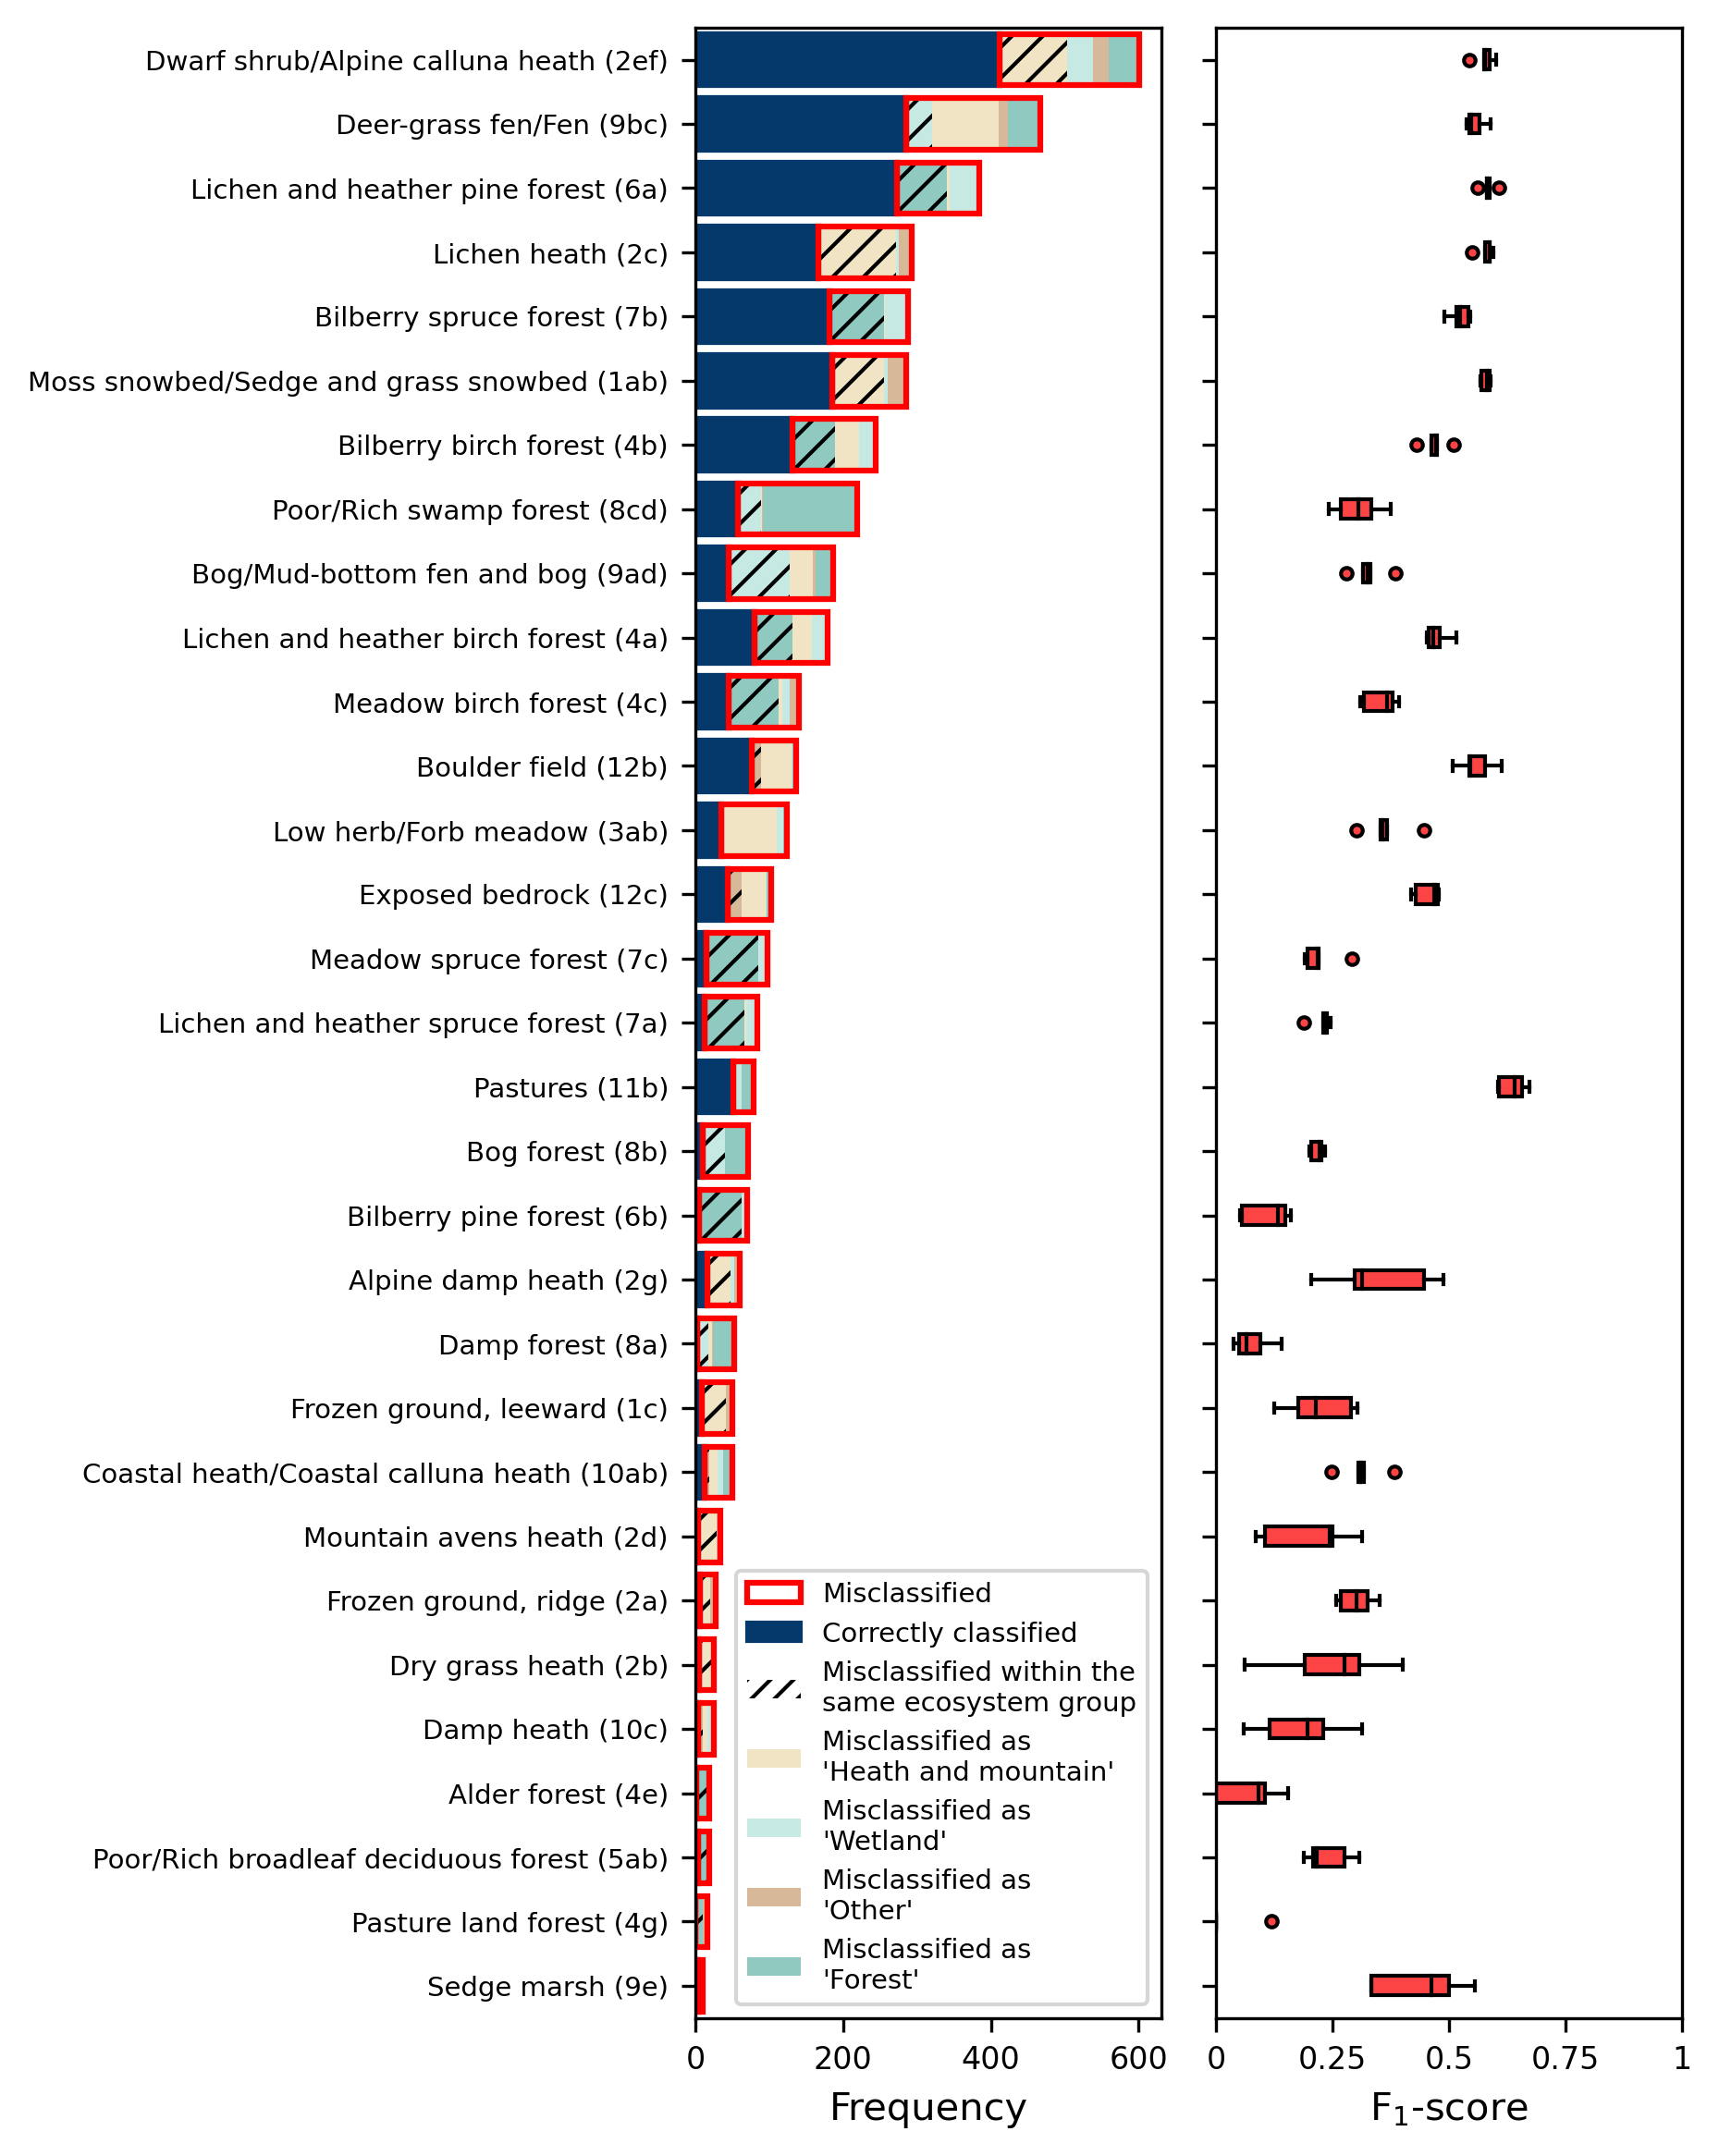

In [15]:
plot_confmat_stacked_bars_and_f1(
    confusion_matrix_cv_results=confusion_matrix_cv_results,
    fold_scores=rf_scoring_class_list,
    #overall_scores=rf_scoring_total_df,
    vt_class_labels=rf.classes_,
    classes_or_group='all',
    draw_legend=True,
    #fig_size=(),
    saveas='class_level_clf_results.png',
    savepath='../results/plots/',
)